In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFCamembertModel, CamembertTokenizer, CamembertConfig,TFBertModel,CamembertTokenizer, TFCamembertForSequenceClassification

tf.random.set_seed(42)
np.random.seed(42)

2023-11-21 14:48:59.939586: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 14:48:59.939661: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 14:48:59.939694: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 14:48:59.949180: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 14:49:01.283659: W tensorflow/compiler/

In [3]:
df = pd.read_excel(io="./data/historique_interventions_IA.xlsx", sheet_name="liste inter CATEGORISEES LIGHT")
df.columns = [title.lower().replace(" ", "_") for title in df.columns]
df.columns

Index(['description', 'activity_text', 's-ens', 'cat'], dtype='object')

In [4]:
df['s-ens_cleaned'] = df['s-ens'].str.lower()
df = df[['description','s-ens_cleaned']]
df.dropna(inplace=True)
df.columns = ['description', "labels"]

In [5]:
count = df.groupby('labels').count().reset_index()

nb_min_to_keep = 10 

result = count[count['description'] > nb_min_to_keep]
result['labels']
nb_targets = result['labels'].nunique()
display(count)

,labels,description
0,autom,13
1,barre ionisante,3
2,bi,5
3,bol bouchon,25
4,cellules,61
5,climet,6
6,communication,18
7,convoyeur entrée,9
8,convoyeur principal,30
9,courroie,1


In [6]:
list_label_to_keep = result['labels'].unique()

In [7]:
df = df[df['labels'].isin(list_label_to_keep)]

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
# Création de l'encodeur
le = LabelEncoder()
nb_targets = df['labels'].nunique()
# Entraînement de l'encodeur et transformation des labels
df['labels_encoded'] = le.fit_transform(df['labels'])

y = df['labels_encoded']


filename = './save_model/labelencoder.pkl'
pickle.dump(le, open(filename, 'wb'))


X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(np.array(df['description']), y,
                                                   test_size=0.2,
                                                   random_state = 0,
                                                   stratify=y,
                                                   shuffle=True)

In [9]:
tokenizer = CamembertTokenizer("./save_model/tokenizer_model.model")

model = TFCamembertModel.from_pretrained("jplu/tf-camembert-base",num_labels=nb_targets)
LONGUEUR_MAX_COMMENTAIRE = df.description.str.len().max()
output_tokenizer_entrainement = tokenizer(list(X_train_nlp),max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)
output_tokenizer_tests = tokenizer(list(X_test_nlp),max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

2023-11-21 14:49:03.166025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 14:49:03.243850: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Some layers from the model checkpoint at jplu/tf-camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architect

In [10]:
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32')
sortie_camemBERT = model([entrees_ids,entrees_masks])

# Instanciation du modèle avec Keras
model_camemBERT = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = sortie_camemBERT,trainable=False)
model_camemBERT.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model (TFCame  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 mbertModel)                 ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                              

In [11]:
output = Dense(nb_targets, activation='softmax')(sortie_camemBERT[1])  # Use pooled representation
model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs=output)
model.layers[2].trainable = False  # Disable training of CamemBERT

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model (TFCame  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 mbertModel)                 ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [12]:
early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_train_nlp,
                    epochs=10, verbose=1, batch_size = 2,callbacks=[early], workers=-1, 
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test_nlp))

Epoch 1/10
208/208 [==============================] - 46s 181ms/step - loss: 2.5865 - accuracy: 0.1490 - val_loss: 2.5084 - val_accuracy: 0.2095
Epoch 2/10
208/208 [==============================] - 34s 163ms/step - loss: 2.4855 - accuracy: 0.1923 - val_loss: 2.4332 - val_accuracy: 0.2000
Epoch 3/10
208/208 [==============================] - 34s 164ms/step - loss: 2.4372 - accuracy: 0.1923 - val_loss: 2.3940 - val_accuracy: 0.2000
Epoch 4/10
208/208 [==============================] - 35s 167ms/step - loss: 2.4000 - accuracy: 0.2043 - val_loss: 2.3714 - val_accuracy: 0.2000
Epoch 5/10
208/208 [==============================] - 35s 167ms/step - loss: 2.3803 - accuracy: 0.1995 - val_loss: 2.3605 - val_accuracy: 0.2000
Epoch 6/10
208/208 [==============================] - 38s 181ms/step - loss: 2.3689 - accuracy: 0.2091 - val_loss: 2.3540 - val_accuracy: 0.2000
Epoch 7/10
208/208 [==============================] - 34s 165ms/step - loss: 2.3673 - accuracy: 0.2163 - val_loss: 2.3496 - val_ac

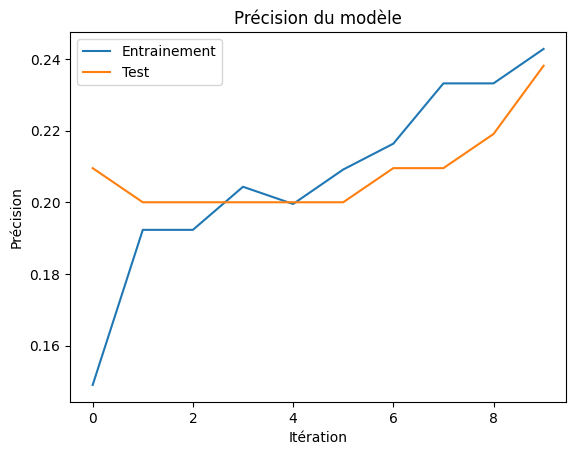

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

In [14]:
model.layers[2].trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model (TFCame  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 mbertModel)                 ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [15]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_train_nlp,
                    epochs=20, verbose=1, batch_size = 8,callbacks=[early], workers=-1, use_multiprocessing=False,
                    validation_data=([output_tokenizer_tests['input_ids'],output_tokenizer_tests['attention_mask']],y_test_nlp))

Epoch 1/20
52/52 [==============================] - 144s 2s/step - loss: 2.1456 - accuracy: 0.3245 - val_loss: 1.6489 - val_accuracy: 0.5714
Epoch 2/20
52/52 [==============================] - 107s 2s/step - loss: 1.1975 - accuracy: 0.6851 - val_loss: 1.2743 - val_accuracy: 0.6095
Epoch 3/20
52/52 [==============================] - 96s 2s/step - loss: 0.6476 - accuracy: 0.8678 - val_loss: 1.2348 - val_accuracy: 0.6571
Epoch 4/20
52/52 [==============================] - 85s 2s/step - loss: 0.8632 - accuracy: 0.7740 - val_loss: 2.2326 - val_accuracy: 0.3810
Epoch 5/20
52/52 [==============================] - 84s 2s/step - loss: 0.3984 - accuracy: 0.9159 - val_loss: 1.3209 - val_accuracy: 0.6857
Epoch 6/20
52/52 [==============================] - 85s 2s/step - loss: 0.1080 - accuracy: 0.9904 - val_loss: 1.2439 - val_accuracy: 0.6952
Epoch 7/20
52/52 [==============================] - 85s 2s/step - loss: 0.0810 - accuracy: 0.9832 - val_loss: 1.2127 - val_accuracy: 0.7429
Epoch 8/20
52/52 [

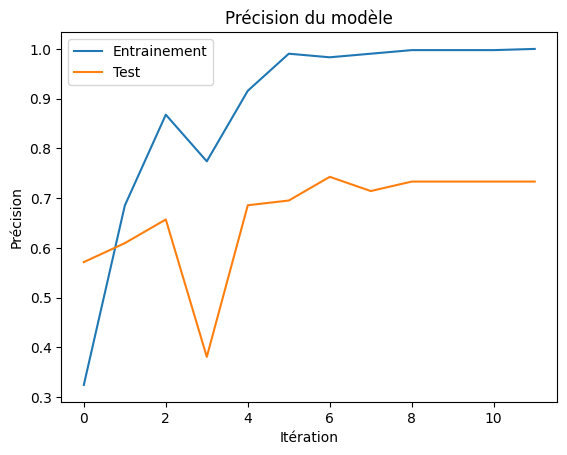

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()

In [17]:
def encode_texts(texts, tokenizer, max_seq_length):
    input_ids = []

    encoded = tokenizer(texts,max_length=max_seq_length, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)
    input_ids.append([encoded["input_ids"],encoded["attention_mask"]])
    return input_ids

def prediction(model, max_seq_length, *args) :
    texts = list(*args)
    to_test = encode_texts(texts=texts, tokenizer=tokenizer, max_seq_length=max_seq_length)
    proba = model.predict(*to_test)
    indexes = np.argmax(proba, axis=1)
    return le.inverse_transform(indexes)

In [24]:
text_test = 'défaut vibration courroie'
test1 = 'cellule flacons retournés HS'
test2 = 'réglage position IPC'
prediction(model, LONGUEUR_MAX_COMMENTAIRE,[text_test,test1,test2])

1/1 [==============================] - 0s 172ms/step


array(['poste bouchonnage', 'cellules ', 'ipc'], dtype=object)

In [23]:
model.predict(encode_texts('réglage position IPC',tokenizer,LONGUEUR_MAX_COMMENTAIRE))

1/1 [==============================] - 3s 3s/step


array([[6.4334943e-04, 1.4356025e-03, 8.4089907e-04, 3.7600361e-02,
        2.5912153e-04, 3.0842431e-02, 9.2426825e-01, 1.4601583e-03,
        2.3222143e-04, 6.9650752e-04, 7.1312906e-04, 4.9262814e-04,
        2.8268230e-04, 2.3259954e-04]], dtype=float32)

In [26]:
le.inverse_transform([6])

array(['ipc'], dtype=object)

In [19]:
model_path = "./save_model/"
date = datetime.now()
model.save(model_path+f"nlp_{nb_targets}_nb_class_{date}.h5")

/home/apprenant/miniconda3/envs/nlp_fail/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# custom_objects = {'TFCamembertModel': TFCamembertModel}
# model_path =  "./nlp_2111_non_aug.h5"
# loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

# loaded_model.summary()